# Pitch Quality Grouped

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball xQual](#Fastball-Leaders)
    - [Fastball HB & VB](#Fastball-HB-&-VB)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball xQual](#Breaking-Ball-Leaders)
    - [Breaking Ball HB & VB](#Breaking-Ball-HB-&-VB)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed xQual](#Off-Speed-Leaders)
    - [Off-Speed HB & VB](#Off-Speed-HB-&-VB)

# Imports

In [74]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [75]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])

xrv_grouped.FF_count = xrv_grouped.FF_count.astype(int)
xrv_grouped.SI_count = xrv_grouped.SI_count.astype(int)
xrv_grouped.FC_count = xrv_grouped.FC_count.astype(int)
xrv_grouped.CU_count = xrv_grouped.CU_count.astype(int)
xrv_grouped.SL_count = xrv_grouped.SL_count.astype(int)
xrv_grouped.KC_count = xrv_grouped.KC_count.astype(int)
xrv_grouped.CH_count = xrv_grouped.CH_count.astype(int)
xrv_grouped.FS_count = xrv_grouped.FS_count.astype(int)

pd.set_option('max_columns', None)
print(xrv_grouped.shape)
xrv_grouped.head()

(705434, 16)


,player_name,p_throws,pitch_type,velo,pfx_x,pfx_z,rv,FF_count,SI_count,FC_count,xRV,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Gsellman, Robert",R,SI,94.3,16.20,10.56,-0.110,0,1,0,0.002900,0,0,0,0,0
1,"Gsellman, Robert",R,SI,94.3,18.24,5.88,-0.047,0,1,0,0.049818,0,0,0,0,0
2,"Gsellman, Robert",R,SI,94.2,17.04,6.36,-0.034,0,1,0,0.087840,0,0,0,0,0
3,"Gsellman, Robert",R,SI,94.1,15.36,4.32,-0.135,0,1,0,0.016247,0,0,0,0,0
4,"Gsellman, Robert",R,SI,93.6,15.48,6.96,-0.135,0,1,0,0.015419,0,0,0,0,0


In [76]:
print(rv_pitches.shape)
rv_pitches.head()

(3402, 11)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,5.7,2.7,2.7,1.3
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,-1.5,-1.5,-3.3,-3.2
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,-1.4,-0.4,1.0,0.3
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,2.3,2.6,-0.2,-0.2
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,3.8,3.0,1.0,0.8


# Preprocessing

In [77]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF')] # & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC')] # & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI')] # & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL')] # & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU')] # & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH')] # & (rv_pitches['n_pitches'] > 100)]
fs = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FS')] # & (rv_pitches['n_pitches'] > 100)]

fb_total = rv_pitches[rv_pitches['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb_total = rv_pitches[rv_pitches['pitch_type'].isin(['SL', 'CU', 'KC'])]
os_total = rv_pitches[rv_pitches['pitch_type'].isin(['CH', 'FS'])]

fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'CU', 'KC'])]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Vertical Break, Horizontal Break, Release Extension

**Dependent Variable:** rv

In [78]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 
                 'pfx_x', 'pfx_z', 'rv']]
# 'spin_rate', 'release_pos_x', 'release_pos_z', 'release_extension', 'arm_angle'

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

  feature       VIF
3      rv  1.001963
1   pfx_x  1.058757
0    velo  1.940509
2   pfx_z  2.008945


# Analysis

### Run Value for Ball in Play by Events

In [79]:
data.groupby(['events'], as_index = False)['lin_weight_above_outs', 'lin_weights_above_outs_scale', 'rv'].mean()

,events,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,1.041,1.259,0.770134
1,field_error,0.716,0.866,0.445453
2,field_out,0.000,0.000,-0.271401
3,game_advisory,0.194,0.235,-0.060667
4,hit_by_pitch,0.630,0.762,0.359255
5,home_run,1.657,2.003,1.385794
6,single,0.746,0.902,0.474625
7,triple,1.334,1.613,1.062984
8,walk,0.603,0.729,0.332287


### Run Value by Count

In [80]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009612,0.002206
1,0-1,0.265,-0.018634,-0.003365
2,0-2,0.197,-0.067630,-0.067365
3,1-0,0.356,-0.008224,0.006870
4,1-1,0.300,-0.021001,0.001974
...,...,...,...,...
8,2-2,0.269,-0.105299,-0.069878
9,3-0,0.540,0.006415,0.096440
10,3-1,0.477,-0.006323,0.083824
11,3-2,0.379,0.011064,0.023962


### Average Run Value by Pitch Type

In [81]:
#xrv_grouped.groupby(['pitch_type'], as_index = False)['velo', 'pfx_x', 'pfx_z', 'rv', 'xRV'].mean().round(2)

rv_pitches.groupby(['pitch_type'], as_index = False, sort = False)['velo', 'HB', 'VB', 'RV', 'RV/100',
                                                                   'xRV', 'xRV/100'].mean().round(2)

,pitch_type,velo,HB,VB,RV,RV/100,xRV,xRV/100
0,FF,93.30,3.33,15.50,-2.81,0.03,-1.88,-0.07
1,FC,88.23,-1.48,8.02,-1.68,0.71,-1.00,0.05
2,SI,92.82,5.71,10.11,-0.45,0.39,0.19,0.36
3,SL,83.53,-2.79,1.88,-3.63,-0.85,-3.32,-0.98
4,CU,77.54,-3.55,-8.10,-2.07,0.06,-1.85,-0.32
5,CH,85.20,6.00,7.41,-1.29,-0.04,-1.05,-0.52
6,FS,85.58,7.70,4.97,-5.04,4.61,-4.41,2.19


# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [82]:
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

fb_r_avg = fb_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'pfx_x', 'pfx_z'].mean()
fb_l_avg = fb_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'pfx_x', 'pfx_z'].mean()
fb_avg = pd.concat([fb_r_avg, fb_l_avg], ignore_index = True)
fb_avg = fb_avg.round(1)
fb_avg.head(6)

,pitch_type,p_throws,velo,pfx_x,pfx_z
0,SI,R,93.4,14.8,9.2
1,FF,R,94.1,7.1,16.1
2,FC,R,89.5,-3.0,7.9
3,FF,L,92.8,-7.5,16.2
4,SI,L,92.1,-15.0,9.3
5,FC,L,86.8,1.7,7.9


In [83]:
fb[['rv', 'xRV']].describe()

,rv,xRV
count,406278.000000,406278.000000
mean,-0.007055,-0.003710
std,0.259753,0.156356
min,-1.860000,-1.182200
25%,-0.060000,-0.060868
50%,-0.034000,-0.017918
75%,0.028000,0.027430
max,3.760000,2.353194


### Fastball xQual Leaders

In [84]:
fb['RV/100'] = round(((fb['rv'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)
fb['xRV/100'] = round(((fb['xRV'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)

#cols = list(fb[['rv', 'xRV']])
#fb[cols]
#
#for col in cols:
#    col_zscore = col + '_zscore'
#    fb[col_zscore] = ((fb[col] - fb[col].mean()) / fb[col].std() * -1)
#
#stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
#                   as_index = False)['FF_count', 'SI_count', 'FC_count',
#                                     'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()
#
#fb = pd.merge(fb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   
#
#fb['Qual'] = fb['rv_zscore_y'] + 100
#fb['xQual'] = fb['xRV_zscore_y'] + 100
#
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

group_stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 'xRV/100'].mean()

stats = pd.merge(stats, group_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
group_stats = group_stats.round(2)
group_stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'FF_count', 'SI_count', 
                                       'FC_count', 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 
                                       'xRV', 'xRV/100'])
#data.rename(columns = {'pfx_-x': 'pfx_x', 'plate_-x': 'plate_x', 'release_pos_-x': 'release_pos_x'}, 
#            inplace = True)

In [85]:
fb_leaders = group_stats.sort_values(by = ['xRV'], ascending = True)
fb_leaders = fb_leaders.round(1)
fb_leaders.head(10)

,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,rv,RV/100,xRV,xRV/100
269,"Cole, Gerrit",R,FF,1397,0,0,97.7,12.0,18.0,-35.5,-2.5,-40.7,-2.9
1116,"Ray, Robbie",L,FF,1864,0,0,94.8,-8.2,17.1,-47.3,-2.5,-35.2,-1.9
1276,"Snell, Blake",L,FF,1230,0,0,95.1,-5.8,18.8,-19.3,-1.6,-28.9,-2.3
1154,"Rodón, Carlos",L,FF,1302,0,0,95.4,-7.9,17.6,-38.1,-2.9,-28.4,-2.2
1460,"Wheeler, Zack",R,FF,1353,0,0,97.2,7.6,15.9,-36.9,-2.7,-26.2,-1.9
228,"Cease, Dylan",R,FF,1377,0,0,96.7,4.4,18.8,-6.9,-0.5,-25.8,-1.9
491,"Gilbert, Logan",R,FF,1305,0,0,95.3,5.4,18.0,-31.1,-2.4,-25.1,-1.9
192,"Burnes, Corbin",R,FC,0,0,1354,95.2,-4.2,11.2,-25.1,-1.9,-23.3,-1.7
847,"Matzek, Tyler",L,FF,753,0,0,96.0,-4.9,18.0,-22.8,-3.0,-21.7,-2.9
526,"Green, Chad",R,FF,854,0,0,95.7,4.5,19.3,-27.0,-3.2,-21.6,-2.5


### RHP Fastball HB & VB xQual

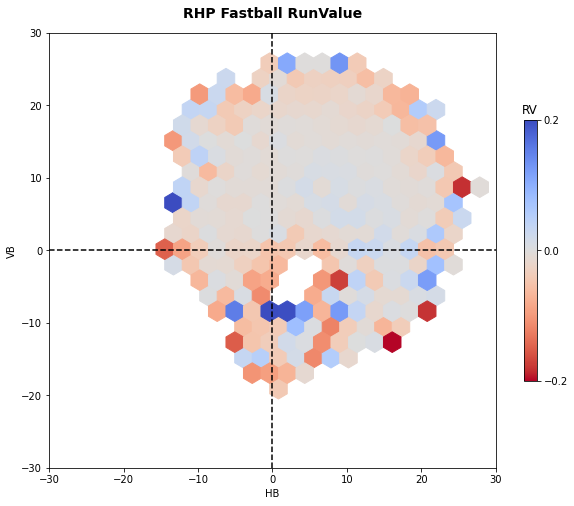

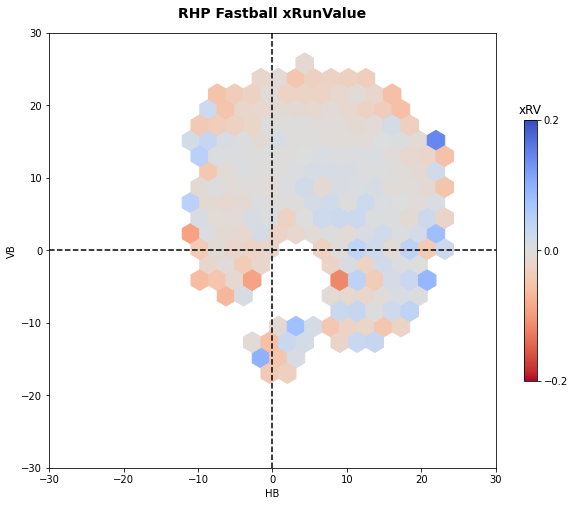

In [86]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['rv'], 
           cmap = 'coolwarm_r', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, 0, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball RunValue', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['xRV'], 
           cmap = 'coolwarm_r', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, 0, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRunValue', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball HB & VB xQual

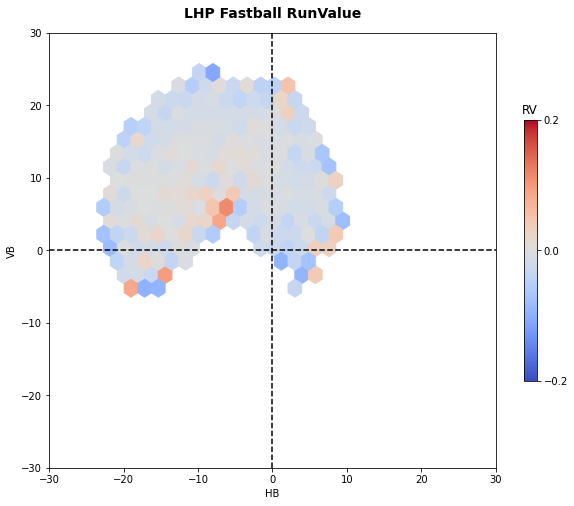

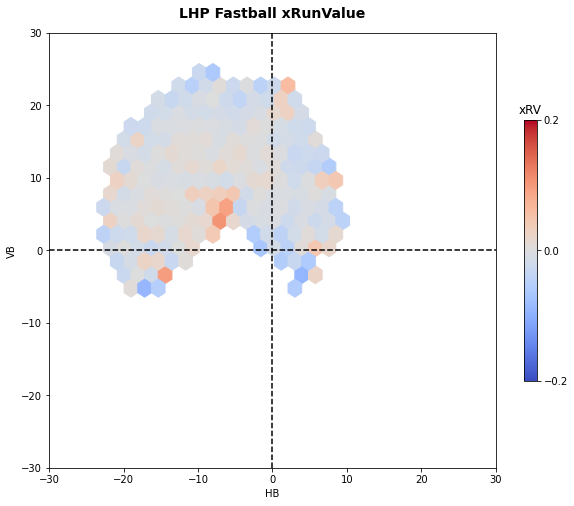

In [89]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['rv'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, 0, .2], shrink = .6)
cb.ax.set_title('RV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball RunValue', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['xRV'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, 0, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRunValue', fontsize = 14, fontweight = 'bold', pad = 15);

If we have a negative z-score the corresponding raw score should be less than the mean, and a positive z-score must correspond to a raw score higher than the mean.

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [90]:
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

bb_r_avg = bb_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'pfx_x', 'pfx_z'].mean()
bb_l_avg = bb_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'pfx_x', 'pfx_z', ].mean()
bb_avg = pd.concat([bb_r_avg, bb_l_avg], ignore_index = True)
bb_avg = bb_avg.round(1)
bb_avg.head(6)

,pitch_type,p_throws,velo,pfx_x,pfx_z
0,SL,R,84.9,-6.3,1.8
1,CU,R,79.2,-9.6,-9.3
2,KC,R,81.5,-8.3,-11.7
3,SL,L,83.9,5.8,1.5
4,CU,L,77.7,8.4,-7.5
5,KC,L,78.9,5.0,-9.0


In [ ]:
bb[['rv', 'xRV']].describe()

## Breaking Ball Leaders

In [ ]:
bb['RV/100'] = round(((bb['rv'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)
bb['xRV/100'] = round(((bb['xRV'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)

cols = list(bb[['rv', 'xRV', 'RV/100', 'xRV/100']])
bb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    bb[col_zscore] = ((bb[col] - bb[col].mean())/ bb[col].std(ddof=0) * -1)

stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['SL_count', 'CU_count', 'KC_count', 
                                         'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()
bb = pd.merge(bb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bb['Qual'] = bb['rv_zscore_y'] + 100
bb['xQual'] = bb['xRV_zscore_y'] + 100
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

q_stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                 as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                                   'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'SL_count', 'CU_count', 'KC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

bb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
bb_leaders.head(10)

In [ ]:
bb[['Qual', 'xQual']].describe()

### RHP Breaking Ball HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [ ]:
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

os_r_avg = os_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'pfx_x', 'pfx_z'].mean()
os_l_avg = os_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'pfx_x', 'pfx_z'].mean()
os_avg = pd.concat([os_r_avg, os_l_avg], ignore_index = True)
os_avg = os_avg.round(1)
os_avg.head(6)

In [ ]:
os[['rv', 'xRV']].describe()

### Off-Speed Leaders

In [ ]:
os['RV/100'] = round(((os['rv'] / (os['CH_count'] + os['FS_count'])) * 100), 2)
os['xRV/100'] = round(((os['xRV'] / (os['CH_count'] + os['FS_count'])) * 100), 2)

cols = list(os[['rv', 'xRV', 'RV/100', 'xRV/100']])
os[cols]

for col in cols:
    col_zscore = col + '_zscore'
    os[col_zscore] = ((os[col] - os[col].mean()) / os[col].std(ddof=0) * -1)

stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['CH_count', 'FS_count', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
os = pd.merge(os, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
os['Qual'] = os['rv_zscore_y'] + 100
os['xQual'] = os['xRV_zscore_y'] + 100
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

q_stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                       'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

os_leaders = stats.sort_values(by = ['xQual'], ascending = False)
os_leaders.head(10)

In [ ]:
os[['Qual', 'xQual']].describe()

### RHP Off-Speed HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Save to CSV

In [ ]:
pitch_quality = pd.concat([fb, bb, os], ignore_index = True)
#pitch_quality.to_csv('../data/pitch-quality.csv')

In [ ]:
print(pitch_quality.shape)
pitch_quality.head()